In [1]:
# ===== Standard Libraries =====
import re
import warnings
import joblib
import matplotlib.pyplot as plt
from collections import defaultdict

# ===== Scientific Computing =====
import numpy as np
import pandas as pd

# ===== TensorFlow / Keras =====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Dot, Lambda
from tensorflow.keras.models import load_model
from tqdm.keras import TqdmCallback

# ===== Keras Tuner =====
import keras_tuner as kt

# ===== Scikit-learn =====
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    average_precision_score,
    ndcg_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# ===== Pandas Display & Warnings =====
from pandas.errors import DtypeWarning
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=DtypeWarning)

	•	reviews_0-250.csv: Contains reviews for products indexed from 0 to 250.  
	•	reviews_250-500.csv: Contains reviews for products indexed from 250 to 500.  
	•	reviews_500-750.csv: Contains reviews for products indexed from 500 to 750.  
	•	reviews_750-1250.csv: Contains reviews for products indexed from 750 to 1250.  
	•	reviews_1250-end.csv: Contains reviews for products indexed from 1250 to the last product in the dataset.  

This segmentation is likely implemented to manage file sizes and facilitate easier data handling. Each file encompasses all reviews associated with the products within the specified index range.

In [2]:
pro_inf = pd.read_csv('../sephora_datasets/product_info.csv')
pro_inf_original = pro_inf.copy()
rew_1 = pd.read_csv('../sephora_datasets/reviews_0-250.csv')
rew_2 = pd.read_csv('../sephora_datasets/reviews_250-500.csv')
rew_3 = pd.read_csv('../sephora_datasets/reviews_500-750.csv')
rew_4 = pd.read_csv('../sephora_datasets/reviews_750-1250.csv')
rew_5 = pd.read_csv('../sephora_datasets/reviews_1250-end.csv')

files = [
    "reviews_0-250.csv",
    "reviews_250-500.csv",
    "reviews_500-750.csv",
    "reviews_750-1250.csv",
    "reviews_1250-end.csv"
]

df_reviews = pd.concat([rew_1, rew_2, rew_3, rew_4, rew_5], ignore_index=True, axis=0)
print("Combined shape:", df_reviews.shape)

Combined shape: (1094411, 19)


### check duplicated rows, the time difference, the rating difference

In [3]:
df_reviews['submission_time'] = pd.to_datetime(df_reviews['submission_time'], errors='coerce')

dupes_first = df_reviews[df_reviews.duplicated(subset=['author_id', 'product_id'], keep=False)]

dupe_stats_first = dupes_first.groupby(['author_id', 'product_id'])[['submission_time', 'rating']].agg(['count', 'min', 'max', 'std'])


dupe_stats_sorted_first = dupe_stats_first.sort_values(by=('rating', 'std'), ascending=False)
### I will display this result a couple of cells below (dupe_stats_sorted_first)
df_reviews_final = df_reviews[['product_id', 'author_id', 'rating']].copy()

### remove dummy users

In [4]:
df_reviews_final = df_reviews_final.loc[~df_reviews_final['author_id'].str.contains(r'[a-zA-Z]', regex=True, na=False), :]

## Inspect users who rate items more than once

In [5]:
# duplicated (user, item) pairs
duplicates = df_reviews_final[df_reviews_final.duplicated(subset=['author_id', 'product_id'], keep=False)]

# how many such duplicates there are
num_duplicates = len(duplicates)
num_unique_duplicated_pairs = duplicates[['author_id', 'product_id']].drop_duplicates().shape[0]

print(f"Total duplicate ratings: {num_duplicates}")
print(f"Number of unique (user, item) pairs with duplicates: {num_unique_duplicated_pairs}")

duplicates.sort_values(['author_id', 'product_id']).head(10)

Total duplicate ratings: 10468
Number of unique (user, item) pairs with duplicates: 4950


,product_id,author_id,rating
27496,P218700,1743286,5
28172,P218700,1743286,5
30937,P218700,6527230,5
31360,P218700,6527230,5
23554,P7880,13038147,5
23903,P7880,13038147,5
22322,P7880,13929258,5
22563,P7880,13929258,5
23250,P7880,23576611,5
23383,P7880,23576611,5


#### This means these users above rated the same item once as 1, and once as 5 — a maximum possible disagreement.

#### Only ~0.45% of our dataset (4,950 out of 1,094,347 rows) involves repeated user–item interactions — which isn’t huge, but still worth considering.

#### we have 10,468 rows in our df_reviews_final where the same user has rated the same item more than once. These are not necessarily all different users or items” just total number of redundant ratings.  

#### There are 4,950 unique combinations of users and items where the same user rated the same item multiple times. So, for example, user A might have rated item X twice, and that counts as one pair, regardless of how many times they rated it.

In [6]:
dupe_stats_sorted_first.head(5)

submission_time                        \
                                 count        min        max   
author_id   product_id                                         
5937911490  P455241                  2 2020-12-28 2020-12-30   
1633325454  P9939                    2 2009-11-10 2010-07-03   
1749521903  P269122                  2 2013-01-09 2014-03-08   
10364075603 P420652                  2 2018-03-15 2020-02-04   
1333540987  P12336                   2 2013-01-10 2013-01-26   

                                                   rating                    
                                               std  count min max       std  
author_id   product_id                                                       
5937911490  P455241      1 days 09:56:28.051789035      2   1   5  2.828427  
1633325454  P9939      166 days 04:04:56.085211660      2   1   5  2.828427  
1749521903  P269122    299 days 02:32:52.953380988      2   1   5  2.828427  
10364075603 P420652    488 days 14:39:31.893111736      2   1   5  2.828427  
1333540987  P12336      11 days 07:31:44.414312283      2   1   5  2.828427

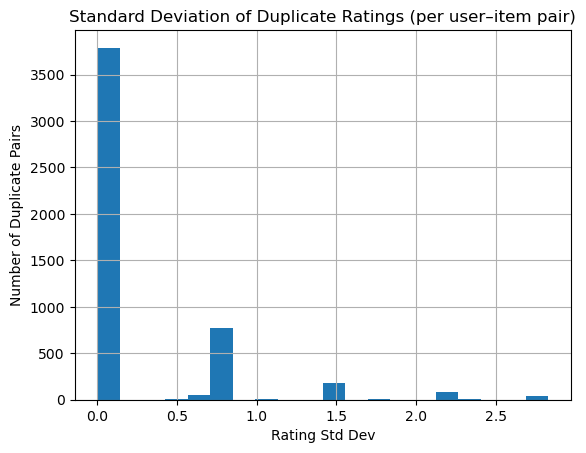

In [7]:
dupe_stats_first[('rating', 'std')].dropna().hist(bins=20)
plt.title('Standard Deviation of Duplicate Ratings (per user–item pair)')
plt.xlabel('Rating Std Dev')
plt.ylabel('Number of Duplicate Pairs')
plt.show()

The vast majority of user–item duplicates (around 3700 out of ~4950) have a standard deviation close to 0:  
	•	This means most users gave the same rating every time they rated the same item.  
	•	These duplicates are redundant but not harmful — they won’t introduce label noise.  
	•	A smaller number (the rest ~1250) show:  
	•	Mild variability (e.g., std ~0.5–1.0): Likely minor rating inconsistencies.  
	•	High variability (e.g., std > 1.5): These are conflicting signals and could be problematic.  

### take the avearege rating for the duplicated (item, user) pairs

In [8]:
df_reviews_final.shape

(1094347, 3)

In [9]:
df_reviews_final = df_reviews_final.groupby(['author_id', 'product_id'], as_index=False)['rating'].mean()

df_reviews_final.shape

(1088829, 3)

In [10]:
df_reviews_final[df_reviews_final.duplicated(subset=['author_id', 'product_id'], keep=False)]

## no duplication anymore

,author_id,product_id,rating


#### check missing values:

In [11]:
display(pro_inf.nunique())
print('************************** missing values:')
display(pro_inf.isnull().sum())

product_id            8494
product_name          8415
brand_id               304
brand_name             304
loves_count           7436
rating                4394
reviews               1556
size                  2055
variation_type           7
variation_value       2729
variation_desc         935
ingredients           6538
price_usd              298
value_price_usd        174
sale_price_usd          88
limited_edition          2
new                      2
online_only              2
out_of_stock             2
sephora_exclusive        2
highlights            4417
primary_category         9
secondary_category      41
tertiary_category      118
child_count             55
child_max_price        222
child_min_price        208
dtype: int64

************************** missing values:


product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
variation_type        1444
variation_value       1598
variation_desc        7244
ingredients            945
price_usd                0
value_price_usd       8043
sale_price_usd        8224
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
child_max_price       5740
child_min_price       5740
dtype: int64

## 1.1 Item Matrix

In [12]:
df = pro_inf.copy()

In [13]:
core_columns_item = [
    'product_id', 'brand_id', 'price_usd', 'limited_edition', 'new',
    'online_only', 'out_of_stock', 'sephora_exclusive', 'primary_category',
    'child_count', 'variation_type'
]
columns_to_impute = ['rating', 'reviews', 'child_max_price', 'child_min_price']
columns_to_drop_item = [
    'product_name', 'brand_name', 'value_price_usd', 'sale_price_usd',
    'variation_value', 'variation_desc', 'tertiary_category', 'secondary_category'
]

In [14]:
df_cleaned = df.drop(columns=columns_to_drop_item)

In [15]:
brand_freq = df_cleaned['brand_id'].value_counts()
df_cleaned['brand_freq'] = df_cleaned['brand_id'].map(brand_freq)

# Log-scaling
# Helps reduce dominance of very high-frequency brands
df_cleaned['brand_freq_log'] = np.log1p(df_cleaned['brand_freq'])  # log(1 + x) to avoid log(0)

# Normalize (MinMax scaling to [0, 1])
scaler = MinMaxScaler()
df_cleaned['brand_freq_scaled'] = scaler.fit_transform(df_cleaned[['brand_freq_log']])

brand_freq_scaled_mapping = (
    df_cleaned[['brand_id', 'brand_freq_scaled']]
    .drop_duplicates(subset='brand_id')
    .set_index('brand_id')
    .squeeze()  # turns DataFrame → Series
    .to_dict()
)

In [16]:
for col in columns_to_impute:
    if col in df_cleaned.columns:
        if col in ['rating', 'child_max_price', 'child_min_price']:
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce').fillna(df_cleaned[col].median())
        elif col == 'reviews':
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce').fillna(0)

# Fill missing categorical with "Unknown"
df_cleaned['primary_category'] = df_cleaned['primary_category'].fillna("Unknown")
#df_cleaned['secondary_category'] = df_cleaned['secondary_category'].fillna("Unknown")
df_cleaned['variation_type'] = df_cleaned['variation_type'].fillna("Unknown")

# One-hot encode variation_type and primary_category (few unique values)
df_encoded = pd.get_dummies(df_cleaned, columns=['variation_type', 'primary_category'], prefix=['var_type', 'pc'])

#### handle size column:

In [17]:
def normalize_size(text):
    """
    Convert the 'size' field to millilitres (mL), with oz converted to mL.
    Solids in g are left as-is. If parsing fails, returns np.nan.
    """
    if pd.isna(text):
        return np.nan
    
    text = str(text).strip().lower()
    
    # Match the first numeric value and a valid unit (ml, mL, g, oz), with optional spaces or separators
    # Handles: "1 oz / 30 ml", "1oz/30ml", ".5 oz / 15 mL", "2 x 0.5oz/15ml"
    m = re.search(r'(?<!\w)([\d.]+)\s*(oz|fl oz|ml|g|mL|grams?)(?!\w)', text)

    if not m:
        return np.nan

    val = m.group(1)
    unit = m.group(2)

    try:
        val = float(val)
    except ValueError:
        return np.nan

    unit = unit.lower()
    if unit in ('ml', 'mL'):
        return val
    elif unit in ('oz', 'fl oz'):
        return val * 29.5735  # Assume oz means fluid oz
    elif unit in ('g', 'gram', 'grams'):
        return val  # Leave solids in g
    else:
        return np.nan

In [18]:
# Apply to DataFrame
df_encoded['size_ml'] = df_encoded['size'].apply(normalize_size)
df_encoded['size_ml_log'] = np.log1p(df_encoded['size_ml'])

df_encoded['size_missing'] = df_encoded['size'].isna().astype(int)
median_size_log = df_encoded['size_ml_log'].median()
df_encoded['size_ml_log'] = df_encoded['size_ml_log'].fillna(median_size_log).copy()
df_encoded = df_encoded.drop(['size_ml', 'size'], axis=1)

In [19]:
# Final item feature matrix
df_encoded = df_encoded.astype({col: 'int' for col in df_encoded.columns if df_encoded[col].dtype == 'bool'})
df_encoded = df_encoded.drop(['brand_id', 'brand_freq', 'brand_freq_log'], axis=1)

In [20]:
item_features_ordered = df_reviews_final[['product_id']].merge(df_encoded, on="product_id", how="left")
item_features_ordered = item_features_ordered.drop(['highlights', 'ingredients'], axis=1)

##### 1.1 finished
## 1.2 User Matrix

In [21]:
print('************************ nunique_values:')
display(df_reviews.nunique())
print('************************ missing values:')
display(df_reviews.isnull().sum())
print('************************ shape:')
print(df_reviews.shape)

************************ nunique_values:


Unnamed: 0                  602130
author_id                   578653
rating                           5
is_recommended                   2
helpfulness                   3767
total_feedback_count           676
total_neg_feedback_count       259
total_pos_feedback_count       590
submission_time               5317
review_text                 969419
review_title                364105
skin_tone                       14
eye_color                        6
skin_type                        4
hair_color                       7
product_id                    2351
product_name                  2334
brand_name                     142
price_usd                      221
dtype: int64

************************ missing values:


Unnamed: 0                       0
author_id                        0
rating                           0
is_recommended              167988
helpfulness                 561592
total_feedback_count             0
total_neg_feedback_count         0
total_pos_feedback_count         0
submission_time                  0
review_text                   1444
review_title                310654
skin_tone                   170539
eye_color                   209628
skin_type                   111557
hair_color                  226768
product_id                       0
product_name                     0
brand_name                       0
price_usd                        0
dtype: int64

************************ shape:
(1094411, 19)


In [22]:
mask_no_feedback = (df_reviews['total_feedback_count'] == 0)
df_reviews.loc[mask_no_feedback, 'helpfulness'] = 0.0

for col in ['skin_tone', 'eye_color', 'skin_type', 'hair_color']:
    df_reviews[col] = df_reviews[col].fillna("Unknown")

user_agg = df_reviews.groupby("author_id").agg({
    "rating": ["mean", "count"],
    "is_recommended": "mean",
    "helpfulness": "mean",
    "skin_tone": "first",
    "skin_type": "first",
    "eye_color": "first",
    "hair_color": "first"
})
user_agg.columns = ['rating_avg', 'rating_count', 'recommend_ratio', 'helpfulness_avg',
                    'skin_tone', 'skin_type', 'eye_color', 'hair_color']
user_agg = user_agg.reset_index()

user_features = pd.get_dummies(user_agg, 
    columns=['skin_tone', 'skin_type', 'eye_color', 'hair_color'],
    prefix=['tone', 'type', 'eye', 'hair'])

global_recommend_avg = df_reviews["is_recommended"].mean()
user_features["recommend_missing"] = user_features["recommend_ratio"].isna().astype(int)
user_features["recommend_ratio"] = user_features["recommend_ratio"].fillna(global_recommend_avg)

user_features = user_features.astype({col: 'int' for col in user_features.columns if user_features[col].dtype == 'bool'})

#### Sentiment Score for review_text

In [23]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df_reviews['sentiment'] = df_reviews['review_text'].fillna("").apply(
    lambda x: analyzer.polarity_scores(x)['compound']
)

user_sentiment = df_reviews.groupby('author_id', sort=False)['sentiment'].mean().reset_index()

In [24]:
user_features = pd.merge(user_features, user_sentiment, on='author_id', how='left')

#### TF-IDF with Truncated Singular Value Decomposition (SVD-k)

In [25]:
tfidf = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)
X_tfidf = tfidf.fit_transform(df_reviews['review_text'].fillna(""))

In [26]:
svd = TruncatedSVD(n_components=128)
X_svd = svd.fit_transform(X_tfidf)

review_embeddings = pd.DataFrame(X_svd)

In [27]:
review_embeddings['author_id'] = df_reviews['author_id'].astype(str).values

user_text_embeddings_df = review_embeddings.groupby('author_id').mean().reset_index()
user_text_embeddings_df.columns = ['author_id'] + [f'user_text_emb_{i}' for i in range(X_svd.shape[1])]

In [28]:
user_features = user_features.merge(user_text_embeddings_df, on='author_id', how='left')

user_text_cols = [col for col in user_features.columns if col.startswith('user_text_emb_')]
user_features['text_emb_missing'] = user_features[user_text_cols[0]].isna().astype(int)
user_features[user_text_cols] = user_features[user_text_cols].fillna(user_features[user_text_cols].mean())

#user_text_embeddings_df['author_id'].nunique()
#user_features['author_id'].nunique() #some users dont have text, so that we have to fill these missing values after merging.

In [29]:
user_features_ordered = df_reviews_final[['author_id']].merge(user_features, on="author_id", how="left")

#### 1.2 finished

### Finalized User-Item DataFrames

In [30]:
user_features_ordered.head()

,author_id,rating_avg,rating_count,recommend_ratio,helpfulness_avg,tone_Unknown,tone_dark,tone_deep,tone_ebony,tone_fair,tone_fairLight,tone_light,tone_lightMedium,tone_medium,tone_mediumTan,tone_notSureST,tone_olive,tone_porcelain,tone_rich,tone_tan,type_Unknown,type_combination,type_dry,type_normal,type_oily,eye_Grey,eye_Unknown,eye_blue,eye_brown,eye_gray,eye_green,eye_hazel,hair_Unknown,hair_auburn,hair_black,hair_blonde,hair_brown,hair_brunette,hair_gray,hair_red,recommend_missing,sentiment,user_text_emb_0,user_text_emb_1,user_text_emb_2,user_text_emb_3,user_text_emb_4,user_text_emb_5,user_text_emb_6,user_text_emb_7,user_text_emb_8,user_text_emb_9,user_text_emb_10,user_text_emb_11,user_text_emb_12,user_text_emb_13,user_text_emb_14,user_text_emb_15,user_text_emb_16,user_text_emb_17,user_text_emb_18,user_text_emb_19,user_text_emb_20,user_text_emb_21,user_text_emb_22,user_text_emb_23,user_text_emb_24,user_text_emb_25,user_text_emb_26,user_text_emb_27,user_text_emb_28,user_text_emb_29,user_text_emb_30,user_text_emb_31,user_text_emb_32,user_text_emb_33,user_text_emb_34,user_text_emb_35,user_text_emb_36,user_text_emb_37,user_text_emb_38,user_text_emb_39,user_text_emb_40,user_text_emb_41,user_text_emb_42,user_text_emb_43,user_text_emb_44,user_text_emb_45,user_text_emb_46,user_text_emb_47,user_text_emb_48,user_text_emb_49,user_text_emb_50,user_text_emb_51,user_text_emb_52,user_text_emb_53,user_text_emb_54,user_text_emb_55,user_text_emb_56,user_text_emb_57,user_text_emb_58,user_text_emb_59,user_text_emb_60,user_text_emb_61,user_text_emb_62,user_text_emb_63,user_text_emb_64,user_text_emb_65,user_text_emb_66,user_text_emb_67,user_text_emb_68,user_text_emb_69,user_text_emb_70,user_text_emb_71,user_text_emb_72,user_text_emb_73,user_text_emb_74,user_text_emb_75,user_text_emb_76,user_text_emb_77,user_text_emb_78,user_text_emb_79,user_text_emb_80,user_text_emb_81,user_text_emb_82,user_text_emb_83,user_text_emb_84,user_text_emb_85,user_text_emb_86,user_text_emb_87,user_text_emb_88,user_text_emb_89,user_text_emb_90,user_text_emb_91,user_text_emb_92,user_text_emb_93,user_text_emb_94,user_text_emb_95,user_text_emb_96,user_text_emb_97,user_text_emb_98,user_text_emb_99,user_text_emb_100,user_text_emb_101,user_text_emb_102,user_text_emb_103,user_text_emb_104,user_text_emb_105,user_text_emb_106,user_text_emb_107,user_text_emb_108,user_text_emb_109,user_text_emb_110,user_text_emb_111,user_text_emb_112,user_text_emb_113,user_text_emb_114,user_text_emb_115,user_text_emb_116,user_text_emb_117,user_text_emb_118,user_text_emb_119,user_text_emb_120,user_text_emb_121,user_text_emb_122,user_text_emb_123,user_text_emb_124,user_text_emb_125,user_text_emb_126,user_text_emb_127,text_emb_missing
0,538863,1.0,1,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.2979,0.253524,0.001548,-0.000663,-0.000726,-0.002936,0.001417,-0.001304,-0.004229,0.003389,0.00505,0.000038,-0.002473,-0.001584,-0.001846,-0.00289,0.003138,0.003225,0.0013,0.000541,0.000214,0.00344,-0.000871,-0.000147,-0.002021,0.000727,0.000903,0.000015,-0.001313,-0.002285,-0.000196,-0.002847,0.001226,-0.000244,0.000463,-0.001894,0.000047,0.001637,-0.001324,0.001684,-0.000569,0.000961,0.000034,-0.000761,0.000264,0.000218,0.000107,0.00054,0.000462,0.000585,-0.000941,0.001471,-0.001147,0.001383,0.000881,0.001006,0.000624,-0.000932,0.000773,-0.00019,-0.000714,-0.000146,-0.00007,0.000661,-0.000386,0.000544,0.000131,0.000227,0.000778,0.000246,-0.000307,-0.000773,-0.000887,0.000034,-0.001114,-0.000209,-0.000175,0.000447,-0.000501,-0.000032,0.000233,0.000193,0.000772,0.000638,0.000439,-0.001236,0.001461,-0.000098,0.000361,-0.001029,-0.000511,-0.001225,-0.000125,-0.000744,0.001083,-0.001132,-0.000186,-0.000495,0.000439,-0.000064,0.000479,-0.000386,-0.000045,0.000433,0.000248,-0.000138,0.000272,-0.00012,0.000366,0.00078,0.000047,-0.000643,-0.000092,-0.000075,0.000692,-0.000238,0.000415,0.000481,-0.000077,-0.000694,0.00043,0.000202,-0.000114,-0.00044,-0.000036,0.000515,0.

In [31]:
item_features_ordered.head()

,product_id,loves_count,rating,reviews,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,child_count,child_max_price,child_min_price,brand_freq_scaled,var_type_Color,var_type_Formulation,var_type_Scent,var_type_Size,var_type_Size + Concentration,var_type_Size + Concentration + Formulation,var_type_Type,var_type_Unknown,pc_Bath & Body,pc_Fragrance,pc_Gifts,pc_Hair,pc_Makeup,pc_Men,pc_Mini Size,pc_Skincare,pc_Tools & Brushes,size_ml_log,size_missing
0,P420652,1081315,4.3508,16118.0,24.0,0,0,0,0,1,3,24.0,24.0,0.510128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.077379,0
1,P218700,134089,4.4998,7763.0,49.0,0,0,0,0,0,2,96.0,18.0,0.480331,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.937202,0
2,P232903,93898,4.2243,3152.0,28.0,0,0,0,0,0,0,32.0,28.0,0.610246,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.420134,0
3,P421998,101394,4.2174,1173.0,56.0,0,0,0,0,0,3,135.0,30.0,0.703143,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.420134,0
4,P445951,29687,4.2174,1173.0,30.0,0,0,0,0,0,0,32.0,28.0,0.703143,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2.759171,0


In [32]:
print('user features: ', user_features_ordered.columns)
print('*********************************')
print('user features: ', item_features_ordered.columns)

user features:  Index(['author_id', 'rating_avg', 'rating_count', 'recommend_ratio',
       'helpfulness_avg', 'tone_Unknown', 'tone_dark', 'tone_deep',
       'tone_ebony', 'tone_fair',
       ...
       'user_text_emb_119', 'user_text_emb_120', 'user_text_emb_121',
       'user_text_emb_122', 'user_text_emb_123', 'user_text_emb_124',
       'user_text_emb_125', 'user_text_emb_126', 'user_text_emb_127',
       'text_emb_missing'],
      dtype='object', length=171)
*********************************
user features:  Index(['product_id', 'loves_count', 'rating', 'reviews', 'price_usd',
       'limited_edition', 'new', 'online_only', 'out_of_stock',
       'sephora_exclusive', 'child_count', 'child_max_price',
       'child_min_price', 'brand_freq_scaled', 'var_type_Color',
       'var_type_Formulation', 'var_type_Scent', 'var_type_Size',
       'var_type_Size + Concentration',
       'var_type_Size + Concentration + Formulation', 'var_type_Type',
       'var_type_Unknown', 'pc_Bath & Body

## 1.3 Final Touches on User & Item Datasets

In [33]:
num_user_features = user_features_ordered.shape[1] - 1
num_item_features = item_features_ordered.shape[1] - 1

u_s = 1  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items

print(num_user_features)
print(num_item_features)

170
32


In [34]:
item_train_df, item_test_df = train_test_split(item_features_ordered, train_size=0.80, shuffle=True, random_state=1)
user_train_df, user_test_df = train_test_split(user_features_ordered, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test = train_test_split(df_reviews_final.rating.to_numpy(), train_size=0.80, shuffle=True, random_state=1)

user_test_ids = user_test_df.author_id.values

In [35]:
# Detect binary columns and scale only non-binary
binary_user_cols = [col for col in user_train_df.columns[1:] if user_train_df[col].dropna().isin([0, 1]).all()]
user_cols_to_scale = [col for col in user_train_df.columns[1:] if col not in binary_user_cols]

binary_item_cols = [col for col in item_train_df.columns[1:] if item_train_df[col].dropna().isin([0, 1]).all()]
item_cols_to_scale = [col for col in item_train_df.columns[1:] if col not in binary_item_cols]

In [36]:
# Scale only selected columns
scalerUser = StandardScaler()
user_train_df[user_cols_to_scale] = scalerUser.fit_transform(user_train_df[user_cols_to_scale])
user_test_df[user_cols_to_scale] = scalerUser.transform(user_test_df[user_cols_to_scale])

scalerItem = StandardScaler()
item_train_df[item_cols_to_scale] = scalerItem.fit_transform(item_train_df[item_cols_to_scale])
item_test_df[item_cols_to_scale] = scalerItem.transform(item_test_df[item_cols_to_scale])

In [37]:
# Convert to numpy for model input
user_train = user_train_df.to_numpy()
user_test = user_test_df.to_numpy()
item_train = item_train_df.to_numpy()
item_test = item_test_df.to_numpy()

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train_scaled = scalerTarget.transform(y_train.reshape(-1, 1))
y_test_scaled = scalerTarget.transform(y_test.reshape(-1, 1))

##### 1.3 finished
## 1.4 Starting Building the Model

In [38]:
num_outputs = 32
tf.random.set_seed(1)

user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs)
])

item_NN = tf.keras.models.Sequential([  
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(num_outputs)
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features,))
vu = user_NN(input_user)
vu = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1), name="vu_normalized")(vu)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features,))
vm = item_NN(input_item)
vm = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1), name="vm_normalized")(vm)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 170)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 32)        │     80,800 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32)        │     45,472 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vu_normalized       │ (None, 32)        │          0 │ sequential[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vm_normalized       │ (None, 32)        │          0 │ sequential_1[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ vu_normalized[0]… │
│                     │                   │            │ vm_normalized[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 126,272 (493.25 KB)

 Trainable params: 126,272 (493.25 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

tf.random.set_seed(1)

model.fit([tf.convert_to_tensor(user_train[:, u_s:], dtype=tf.float32), tf.convert_to_tensor(item_train[:, i_s:], dtype=tf.float32)], tf.convert_to_tensor(y_train_scaled, dtype=tf.float32), epochs=30)

Epoch 1/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 19s 676us/step - loss: 0.0937
Epoch 2/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 18s 674us/step - loss: 0.0832
Epoch 3/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 19s 685us/step - loss: 0.0821
Epoch 4/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 20s 726us/step - loss: 0.0814
Epoch 5/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 20s 750us/step - loss: 0.0808
Epoch 6/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 20s 728us/step - loss: 0.0801
Epoch 7/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 19s 704us/step - loss: 0.0795
Epoch 8/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 19s 709us/step - loss: 0.0788
Epoch 9/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 19s 706us/step - loss: 0.0783
Epoch 10/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 19s 704us/step - loss: 0.0777
Epoch 11/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 19s 707us/step - loss: 0.0772
Epoch 12/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 19s 710us/step - loss: 0.0766
Epoch 13/30
27221/27221 ━━━━━━━━━━━━━━━━━━━━ 19s 709us/step - loss: 0.0762
Epoch 14/30
27221/27221 ━━━━━━━━━━

#### 1.4 finished

##### Draw epoch vs Loss

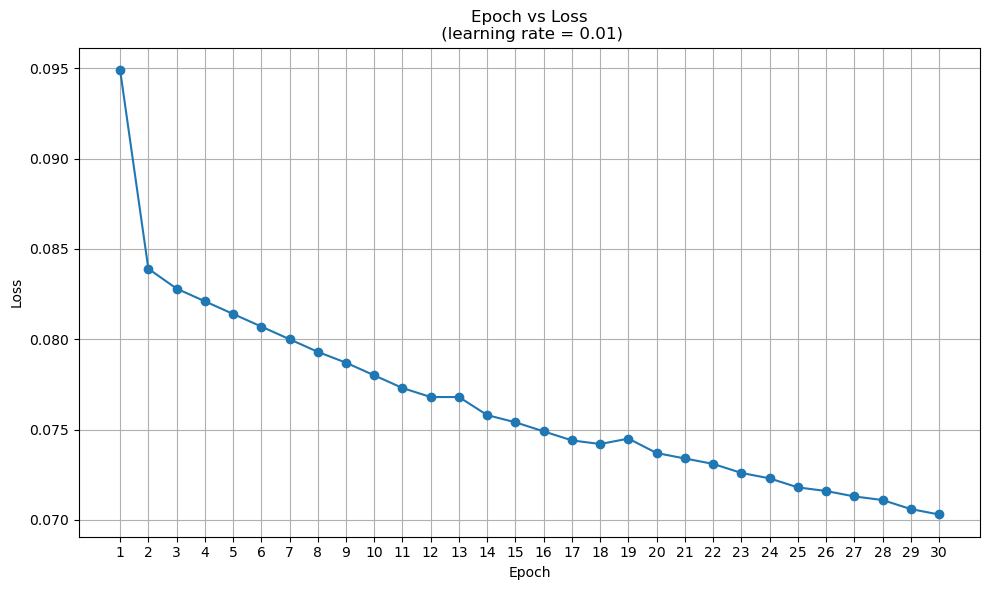

In [40]:
loss_values = [
    0.0949, 0.0839, 0.0828, 0.0821, 0.0814, 0.0807, 0.0800, 0.0793, 0.0787, 0.0780,
    0.0773, 0.0768, 0.0768, 0.0758, 0.0754, 0.0749, 0.0744, 0.0742, 0.0745, 0.0737,
    0.0734, 0.0731, 0.0726, 0.0723, 0.0718, 0.0716, 0.0713, 0.0711, 0.0706, 0.0703
]

epochs = list(range(1, len(loss_values) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o')
plt.title('Epoch vs Loss\n (learning rate = 0.01)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

### MAE, RMSE, MSE

In [41]:
# Apply the SAME scalers used on training data
model.evaluate(
    [tf.convert_to_tensor(user_test[:, u_s:], dtype=tf.float32),
     tf.convert_to_tensor(item_test[:, i_s:], dtype=tf.float32)],
    tf.convert_to_tensor(y_test_scaled, dtype=tf.float32)
)

6806/6806 ━━━━━━━━━━━━━━━━━━━━ 2s 292us/step - loss: 0.0935


0.09262729436159134

In [42]:
# Predict on scaled test data
y_pred_scaled = model.predict([
    tf.convert_to_tensor(user_test[:, u_s:], dtype=tf.float32),
    tf.convert_to_tensor(item_test[:, i_s:], dtype=tf.float32)
])

# Inverse transform predictions and true ratings back to original scale
y_pred_orig = scalerTarget.inverse_transform(y_pred_scaled)
y_test_orig = scalerTarget.inverse_transform(y_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mse = mean_squared_error(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)

print("Test RMSE:", rmse)
print("Test MSE:", mse)
print("Test MAE:", mae)

6806/6806 ━━━━━━━━━━━━━━━━━━━━ 2s 326us/step
Test RMSE: 0.608694596615214
Test MSE: 0.370509111948558
Test MAE: 0.3293839032535204


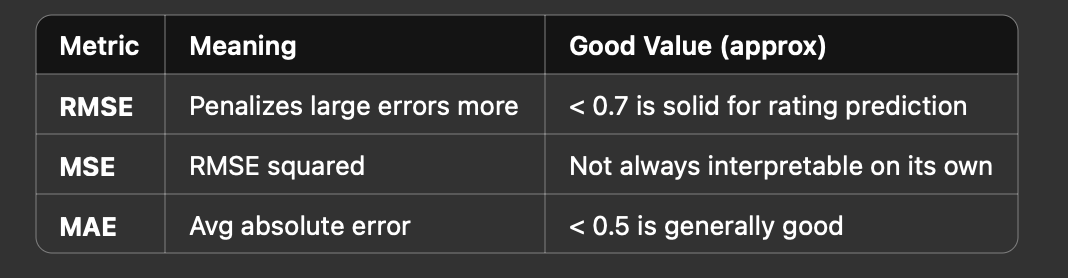

## avg_precision, avg_recall, avg_f1, avg_accuracy

In [43]:
"""
def precision_recall_f1_nn(user_ids_test, y_test_orig, y_pred_orig, threshold=3.5):
    '''
    Computes average precision, recall, F1, and accuracy across users.
    
    Parameters:
      - user_ids_test: array-like, user IDs corresponding to each test row.
      - y_test_orig: array-like, true ratings in the original scale.
      - y_pred_orig: array-like, predicted ratings in the original scale.
      - threshold: float, threshold to decide if a rating is considered 'positive'
    
    Returns:
      avg_precision, avg_recall, avg_f1, avg_accuracy
    '''
    
    # Map predictions and true ratings to user IDs
    user_est_true = defaultdict(list)
    for uid, true_r, est in zip(user_ids_test, y_test_orig, y_pred_orig):
        user_est_true[uid].append((est, true_r))
    
    precisions = {}
    recalls = {}
    f1s = {}
    accuracies = {}
    
    for uid, ratings in user_est_true.items():
        # Create binary labels: 1 if rating >= threshold, else 0
        y_true = [1 if (true_r >= threshold) else 0 for (_, true_r) in ratings]
        y_pred_labels = [1 if (est >= threshold) else 0 for (est, _) in ratings]
        
        precisions[uid] = precision_score(y_true, y_pred_labels, zero_division=0)
        recalls[uid] = recall_score(y_true, y_pred_labels, zero_division=0)
        f1s[uid] = f1_score(y_true, y_pred_labels, zero_division=0)
        accuracies[uid] = accuracy_score(y_true, y_pred_labels)
    
    # Average the scores over all users
    avg_precision = sum(precisions.values()) / len(precisions) if precisions else 0.
    avg_recall = sum(recalls.values()) / len(recalls) if recalls else 0.
    avg_f1 = sum(f1s.values()) / len(f1s) if f1s else 0.
    avg_accuracy = sum(accuracies.values()) / len(accuracies) if accuracies else 0.
    
    return avg_precision, avg_recall, avg_f1, avg_accuracy
"""
print('ignored')

ignored


In [44]:
"""
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1_nn(
    user_ids_test=user_test_ids, 
    y_test_orig=y_test_orig.reshape(-1),  # flatten if necessary
    y_pred_orig=y_pred_orig.reshape(-1),
    threshold=3.5
)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)
print("Average Accuracy:", avg_accuracy)
"""
print('ignored')

ignored


In [45]:
def precision_recall_f1_nn_vectorized(user_ids_test, y_test_orig, y_pred_orig, threshold=3.5):
    """
    Computes average precision, recall, F1, and accuracy across users in a vectorized manner.
    
    Parameters:
      - user_ids_test: array-like, user IDs for each test record.
      - y_test_orig: array-like, true ratings in the original scale.
      - y_pred_orig: array-like, predicted ratings in the original scale.
      - threshold: float, threshold above which a rating is considered "positive".
      
    Returns:
      avg_precision, avg_recall, avg_f1, avg_accuracy
    """
    
    y_true_bin = (np.array(y_test_orig).flatten() >= threshold).astype(int)
    y_pred_bin = (np.array(y_pred_orig).flatten() >= threshold).astype(int)
    
    df = pd.DataFrame({
        'user': user_ids_test,
        'true': y_true_bin,
        'pred': y_pred_bin
    })
    
    # Group by user and compute aggregated statistics:
    # - n_tp: number of true positives
    # - n_pred: total predicted positives
    # - n_true: total actual positives
    # - n_total: total number of ratings for the user
    # - n_correct: total correct predictions
    grouped = df.groupby('user').agg(
        n_tp = ('true', lambda x: np.sum(x * df.loc[x.index, 'pred'])),
        n_pred = ('pred', 'sum'),
        n_true = ('true', 'sum'),
        n_total = ('true', 'size'),
        n_correct = ('true', lambda x: np.sum(x == df.loc[x.index, 'pred']))
    )
    
    grouped['precision'] = grouped['n_tp'] / grouped['n_pred'].replace(0, np.nan)
    grouped['recall'] = grouped['n_tp'] / grouped['n_true'].replace(0, np.nan)
    grouped['accuracy'] = grouped['n_correct'] / grouped['n_total']
    grouped['f1'] = 2 * (grouped['precision'] * grouped['recall']) / (grouped['precision'] + grouped['recall'])
    
    grouped = grouped.fillna(0)
    
    avg_precision = grouped['precision'].mean()
    avg_recall = grouped['recall'].mean()
    avg_f1 = grouped['f1'].mean()
    avg_accuracy = grouped['accuracy'].mean()
    
    return avg_precision, avg_recall, avg_f1, avg_accuracy

In [46]:
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1_nn_vectorized(
    user_ids_test=user_test_ids, 
    y_test_orig=y_test_orig, 
    y_pred_orig=y_pred_orig, 
    threshold=3.5
)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)
print("Average Accuracy:", avg_accuracy)

Average Precision: 0.7876816915316569
Average Recall: 0.795813569644666
Average F1 Score: 0.7900671623952702
Average Accuracy: 0.9366572280360934


## Average Precision, nDCG@k, Average Precision@k

In [47]:
def measures_at_k_nn(user_ids_test, y_test_orig, y_pred_orig, k=10, threshold=3.5):
    """
    Computes average average_precision, precision@k, and nDCG@k across users
    for predictions from a two-tower model.
    
    Parameters:
      - user_ids_test: array-like of user IDs (one per test record)
      - y_test_orig: array-like of true ratings (original scale)
      - y_pred_orig: array-like of predicted ratings (original scale)
      - k: int, the number of top items to consider for "at k" metrics
      - threshold: float, the rating value at or above which an item is considered relevant
      
    Returns:
      avg_average_precision, avg_precision_at_k, avg_ndcg_at_k
    """
    user_ids_test = np.array(user_ids_test).flatten()
    y_test_orig = np.array(y_test_orig).flatten()
    y_pred_orig = np.array(y_pred_orig).flatten()
    
    df = pd.DataFrame({
        'user': user_ids_test,
        'true': y_test_orig,
        'pred': y_pred_orig
    })
    
    df['true_bin'] = (df['true'] >= threshold).astype(int)
    df['pred_bin'] = (df['pred'] >= threshold).astype(int)
    
    user_est_true = df.groupby('user')
    
    average_precisions = {}
    precisions_at_k = {}
    ndcgs_at_k = {}
    
    for uid, group in user_est_true:
        # Convert each user's group to a list of tuples: (predicted rating, true rating, binary true)
        # Sort the user’s items by predicted rating in descending order.
        sorted_group = group.sort_values(by='pred', ascending=False)
        y_true = sorted_group['true_bin'].tolist()
        y_pred = sorted_group['pred_bin'].tolist()
        
        y_true_at_k = y_true[:k]
        y_pred_at_k = y_pred[:k]
        
        # Compute average precision over the full ranked list if the user has any relevant items.
        if sum(y_true) > 0:
            average_precisions[uid] = average_precision_score(sorted_group['true_bin'], sorted_group['pred_bin'])
        else:
            average_precisions[uid] = 0.0
        
        # Compute precision at k.
        precisions_at_k[uid] = precision_score(y_true_at_k, y_pred_at_k, zero_division=0)
        
        # For nDCG, raw ratings are needed and consider the ranking.
        # nDCG expects input arrays of shape (1, n); convert the sorted true and predicted ratings.
        if len(sorted_group) > 1:
            true_rel = np.asarray(sorted_group['true'].tolist()).reshape(1, -1)
            pred_rel = np.asarray(sorted_group['pred'].tolist()).reshape(1, -1)
            ndcgs_at_k[uid] = ndcg_score(true_rel, pred_rel, k=k)
        else:
            # If there's only one item, then return a simple binary match.
            ndcgs_at_k[uid] = 1.0 if (y_true[0] == y_pred[0] and y_true[0] == 1) else 0.0
    
    # Average metrics across all users.
    avg_average_precision = np.mean(list(average_precisions.values()))
    avg_precision_at_k = np.mean(list(precisions_at_k.values()))
    avg_ndcg_at_k = np.mean(list(ndcgs_at_k.values()))
    
    return avg_average_precision, avg_precision_at_k, avg_ndcg_at_k

In [48]:
avg_ap, avg_prec_k, avg_ndcg_k = measures_at_k_nn(user_test_ids, y_test_orig, y_pred_orig, k=10, threshold=3.5)
print("Avg. Average Precision:", avg_ap)
print("Avg. Precision@10:", avg_prec_k)
print("Avg. nDCG@10:", avg_ndcg_k)

Avg. Average Precision: 0.813319559543047
Avg. Precision@10: 0.7876876287474058
Avg. nDCG@10: 0.8158170465912239


# 1.5 hyperparameter tuning

In [49]:
#Train / Val / Test split
item_train_full, item_test_df = train_test_split(
    item_features_ordered, train_size=0.80, random_state=1, shuffle=True)
user_train_full, user_test_df = train_test_split(
    user_features_ordered, train_size=0.80, random_state=1, shuffle=True)
y_train_full, y_test = train_test_split(
    df_reviews_final.rating.to_numpy(), train_size=0.80, random_state=1, shuffle=True)

item_train_df, item_val_df = train_test_split(
    item_train_full, train_size=0.80, random_state=1, shuffle=True)
user_train_df, user_val_df = train_test_split(
    user_train_full, train_size=0.80, random_state=1, shuffle=True)
y_train, y_val = train_test_split(
    y_train_full, train_size=0.80, random_state=1, shuffle=True)

user_test_ids = user_test_df.author_id.values

In [50]:
#Scale non‑binary columns
def detect_binary(df):
    return [c for c in df.columns[1:] if df[c].dropna().isin([0, 1]).all()]

binary_user = detect_binary(user_train_df)
binary_item = detect_binary(item_train_df)

user_cols_to_scale = [c for c in user_train_df.columns[1:] if c not in binary_user]
item_cols_to_scale = [c for c in item_train_df.columns[1:] if c not in binary_item]

scalerUser = StandardScaler().fit(user_train_df[user_cols_to_scale])
scalerItem = StandardScaler().fit(item_train_df[item_cols_to_scale])

for _df in [user_train_df, user_val_df, user_test_df]:
    _df[user_cols_to_scale] = scalerUser.transform(_df[user_cols_to_scale])

for _df in [item_train_df, item_val_df, item_test_df]:
    _df[item_cols_to_scale] = scalerItem.transform(_df[item_cols_to_scale])

item_train_df_cols = item_train_df.columns
item_train_df_cols = [col for col in item_train_df_cols if col != 'product_id']

user_train_df_cols = user_train_df.columns
user_train_df_cols = [col for col in user_train_df_cols if col != 'author_id']

# target scaler
scalerTarget = MinMaxScaler(feature_range=(-1, 1)).fit(y_train.reshape(-1, 1))

In [51]:
# drop non‑numeric IDs and convert to float32
user_train = user_train_df.drop(columns="author_id").to_numpy(np.float32)
user_val   = user_val_df.drop(columns="author_id").to_numpy(np.float32)
user_test  = user_test_df.drop(columns="author_id").to_numpy(np.float32)

item_train = item_train_df.drop(columns="product_id").to_numpy(np.float32)
item_val   = item_val_df.drop(columns="product_id").to_numpy(np.float32)
item_test  = item_test_df.drop(columns="product_id").to_numpy(np.float32)

y_train_scaled = scalerTarget.transform(y_train.reshape(-1, 1)).astype(np.float32)
y_val_scaled   = scalerTarget.transform(y_val.reshape(-1, 1)).astype(np.float32)
y_test_scaled  = scalerTarget.transform(y_test.reshape(-1, 1)).astype(np.float32)
y_train_full_scaled = scalerTarget.transform(y_train_full.reshape(-1, 1)).astype(np.float32)

NUM_USER_FEATURES = user_train.shape[1]          # IDs already dropped → no -1
NUM_ITEM_FEATURES = item_train.shape[1]

In [52]:
#Model‑building function
def build_two_tower(hp: kt.HyperParameters) -> keras.Model:
    embed_dim = hp.Int("embedding_dim", 16, 128, step=16, default=32)

    def tower(prefix: str, n_features: int) -> keras.Sequential:
        seq = keras.Sequential(name=f"{prefix}_tower")
        # for reproducibility make the *baseline* (256,128) reachable
        units1 = hp.Int(f"{prefix}_dense1", 64, 512, step=64, default=256)
        units2 = hp.Int(f"{prefix}_dense2", 32, 256, step=32, default=128)
        seq.add(Dense(units1, activation="relu"))
        seq.add(Dense(units2, activation="relu"))
        seq.add(Dense(embed_dim))
        return seq

    user_in = Input((NUM_USER_FEATURES,), name="user_in")
    item_in = Input((NUM_ITEM_FEATURES,), name="item_in")

    vu = tower("u", NUM_USER_FEATURES)(user_in)
    vm = tower("i", NUM_ITEM_FEATURES)(item_in)

    def l2_normalize(x):
        return tf.math.l2_normalize(x, axis=1)

    def to_float32(t):
        return tf.cast(t, tf.float32)

    #vu = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(vu)
    #vm = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(vm)
    #dot = Dot(axes=1)([vu, vm])
    #out = Lambda(lambda t: tf.cast(t, tf.float32))(dot)

    vu = Lambda(l2_normalize)(vu)
    vm = Lambda(l2_normalize)(vm)
    dot = Dot(axes=1)([vu, vm])
    out = Lambda(to_float32)(dot)

    model = keras.Model([user_in, item_in], out)
    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log", default=1e-3)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

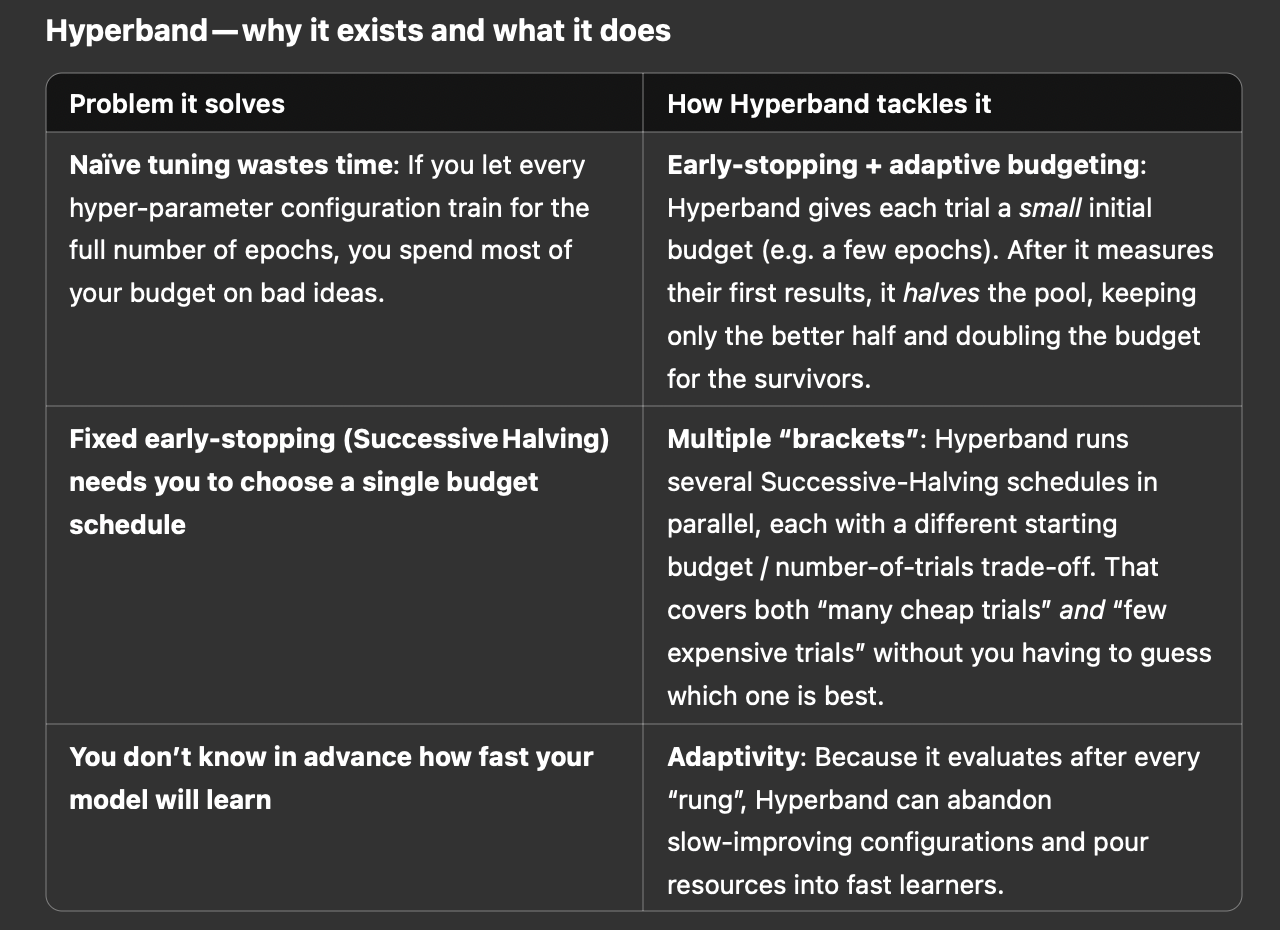

In [53]:
#Hyper‑parameter tuning  (Hyperband)
tuner = kt.Hyperband(
    build_two_tower,
    objective=kt.Objective("val_rmse", "min"),
    max_epochs=30,
    factor=3,
    directory="kt_tuner_v2",
    project_name="two_tower_hb",
    overwrite=True
)

stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

tuner.search(
    x=[user_train, item_train],
    y=y_train_scaled,
    validation_data=([user_val, item_val], y_val_scaled),
    batch_size=256,
    callbacks=[stop],
    verbose=2
)

best_hp = tuner.get_best_hyperparameters(1)[0]

Trial 90 Complete [00h 00m 54s]
val_rmse: 0.29084888100624084

Best val_rmse So Far: 0.28792110085487366
Total elapsed time: 00h 28m 59s


##### 1.5 finished
## 1.6 Test set prediction

In [54]:
# ──────────────────────────────────────────────────────────────
# 5.  *** FINAL FIT on full 80 % (train + val) ***
# ──────────────────────────────────────────────────────────────
final_model = build_two_tower(best_hp)
final_model.fit(
    [np.concatenate([user_train, user_val]), np.concatenate([item_train, item_val])],
    np.concatenate([y_train_scaled, y_val_scaled]),
    epochs=30,
    batch_size=256,
    callbacks=[stop],
    verbose=2
)

Epoch 1/30
3403/3403 - 5s - 2ms/step - loss: 0.0896 - rmse: 0.2993
Epoch 2/30


/opt/anaconda3/envs/webmining/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse
  current = self.get_monitor_value(logs)


3403/3403 - 5s - 1ms/step - loss: 0.0834 - rmse: 0.2888
Epoch 3/30
3403/3403 - 5s - 1ms/step - loss: 0.0824 - rmse: 0.2870
Epoch 4/30
3403/3403 - 5s - 1ms/step - loss: 0.0817 - rmse: 0.2859
Epoch 5/30
3403/3403 - 5s - 1ms/step - loss: 0.0811 - rmse: 0.2849
Epoch 6/30
3403/3403 - 5s - 1ms/step - loss: 0.0806 - rmse: 0.2839
Epoch 7/30
3403/3403 - 5s - 1ms/step - loss: 0.0801 - rmse: 0.2831
Epoch 8/30
3403/3403 - 5s - 1ms/step - loss: 0.0797 - rmse: 0.2824
Epoch 9/30
3403/3403 - 5s - 1ms/step - loss: 0.0794 - rmse: 0.2817
Epoch 10/30
3403/3403 - 5s - 1ms/step - loss: 0.0790 - rmse: 0.2811
Epoch 11/30
3403/3403 - 5s - 1ms/step - loss: 0.0787 - rmse: 0.2806
Epoch 12/30
3403/3403 - 5s - 1ms/step - loss: 0.0784 - rmse: 0.2800
Epoch 13/30
3403/3403 - 5s - 1ms/step - loss: 0.0782 - rmse: 0.2796
Epoch 14/30
3403/3403 - 5s - 1ms/step - loss: 0.0779 - rmse: 0.2792
Epoch 15/30
3403/3403 - 5s - 1ms/step - loss: 0.0777 - rmse: 0.2788
Epoch 16/30
3403/3403 - 5s - 1ms/step - loss: 0.0775 - rmse: 0.2784

/var/folders/0s/63ktljj55t12qgn_8z4nq4wm0000gn/T/ipykernel_60590/1897762422.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


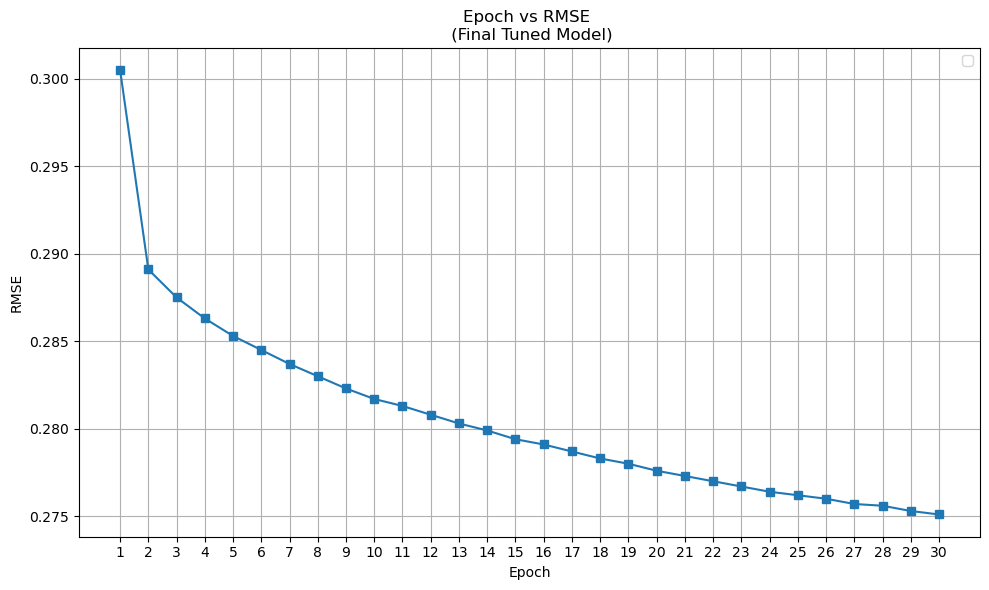

In [55]:
loss_values = [
    0.0903, 0.0836, 0.0826, 0.0820, 0.0814, 0.0809, 0.0805, 0.0801, 0.0797, 0.0794,
    0.0791, 0.0788, 0.0786, 0.0783, 0.0781, 0.0779, 0.0777, 0.0775, 0.0773, 0.0771,
    0.0769, 0.0767, 0.0766, 0.0764, 0.0763, 0.0762, 0.0760, 0.0759, 0.0758, 0.0757
]

rmse_values = [
    0.3005, 0.2891, 0.2875, 0.2863, 0.2853, 0.2845, 0.2837, 0.2830, 0.2823, 0.2817,
    0.2813, 0.2808, 0.2803, 0.2799, 0.2794, 0.2791, 0.2787, 0.2783, 0.2780, 0.2776,
    0.2773, 0.2770, 0.2767, 0.2764, 0.2762, 0.2760, 0.2757, 0.2756, 0.2753, 0.2751
]

epochs = list(range(1, 31))

plt.figure(figsize=(10, 6))
#plt.plot(epochs, loss_values, label='Loss', marker='o')
plt.plot(epochs, rmse_values, marker='s')
plt.title('Epoch vs RMSE \n (Final Tuned Model)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(epochs)
plt.legend()
plt.tight_layout()
plt.show()

#### Measure the performance of the hypertuned final model on the test set

In [56]:
# Evaluation on untouched 20 % test split
scaled_rmse = final_model.evaluate(
    [user_test, item_test], y_test_scaled, verbose=0
)[1]
y_pred_scaled = final_model.predict([user_test, item_test], verbose=0)
y_pred_orig = scalerTarget.inverse_transform(y_pred_scaled)
y_test_orig = scalerTarget.inverse_transform(y_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mse  = mean_squared_error(y_test_orig, y_pred_orig)
mae  = mean_absolute_error(y_test_orig, y_pred_orig)

print("\n────────  Final results on TEST  ────────")
print(f"Scaled RMSE : {scaled_rmse: .4f}")
print(f"Orig  RMSE  : {rmse: .4f}")
print(f"Orig  MSE   : {mse: .4f}")
print(f"Orig  MAE   : {mae: .4f}")

#ranking metrics
prec, rec, f1, acc = precision_recall_f1_nn_vectorized(
    user_test_ids, y_test_orig, y_pred_orig, threshold=3.5)
map_, p10, ndcg10 = measures_at_k_nn(
    user_test_ids, y_test_orig, y_pred_orig, k=10, threshold=3.5)

print(f"PRF/A  : {prec:.3f} / {rec:.3f} / {f1:.3f} / {acc:.3f}")
print(f"MAP / P@10 / nDCG@10 : {map_:.3f} / {p10:.3f} / {ndcg10:.3f}")


────────  Final results on TEST  ────────
Scaled RMSE :  0.2911
Orig  RMSE  :  0.5823
Orig  MSE   :  0.3390
Orig  MAE   :  0.3155
PRF/A  : 0.788 / 0.796 / 0.790 / 0.941
MAP / P@10 / nDCG@10 : 0.813 / 0.788 / 0.817


#### 1.6 finished
## 1.7 Find the Most Similar Products

In [57]:
item_train_df_cols[:5] #column order used in training

['loves_count', 'rating', 'reviews', 'price_usd', 'limited_edition']

In [58]:
user_train_df_cols[:5] #column order used in training

['rating_avg',
 'rating_count',
 'recommend_ratio',
 'helpfulness_avg',
 'tone_Unknown']

In [59]:
#Drop duplicate product_ids
item_features_unique = item_features_ordered.drop_duplicates(subset="product_id", keep="first")

#Separate numeric and binary columns
prod_ids = item_features_unique["product_id"].to_numpy()
item_numeric = item_features_unique.drop(columns=["product_id"])

if hasattr(scalerItem, "feature_names_in_"):
    cols_to_scale = list(scalerItem.feature_names_in_)
else:
    raise ValueError("scalerItem must include feature_names_in_")

#Apply scaling
scaled_numeric = scalerItem.transform(item_numeric[cols_to_scale])
unchanged_cols = [c for c in item_numeric.columns if c not in cols_to_scale]
unchanged_part = item_numeric[unchanged_cols]

scaled_numeric_df = pd.DataFrame(
    scaled_numeric,
    columns=cols_to_scale,
    index=item_numeric.index
)

item_matrix_scaled_df = pd.concat([scaled_numeric_df, unchanged_part], axis=1)
item_matrix_scaled_df = item_matrix_scaled_df[item_train_df_cols]
item_matrix_scaled = item_matrix_scaled_df.to_numpy(dtype=np.float32)

#Build item embedding extractor
item_in = final_model.inputs[1]
vm_layer = final_model.get_layer("lambda_4").output
item_encoder = keras.Model(inputs=item_in, outputs=vm_layer)

#Extract item embeddings
vm_all = item_encoder.predict(item_matrix_scaled, batch_size=1024, verbose=0)

# Nearest-neighbor search using vectorized L2 squared distance
def most_similar_items(query_prod_id, top_k=5):
    try:
        q_idx = np.where(prod_ids == query_prod_id)[0][0]
    except IndexError:
        raise ValueError(f"Product ID '{query_prod_id}' not found!")

    q_vec = vm_all[q_idx]  # shape (embed_dim,)
    dists = (np.sum(vm_all**2, axis=1) +
             np.sum(q_vec**2) -
             2 * vm_all @ q_vec)

    # Get top_k closest items (excluding the query item itself)
    nearest = np.argsort(dists)
    nearest = nearest[nearest != q_idx]  # exclude self

    # ensure unique product_ids in result (just in case)
    seen = set()
    unique_nearest = []
    for idx in nearest:
        pid = prod_ids[idx]
        if pid not in seen:
            seen.add(pid)
            unique_nearest.append(idx)
        if len(unique_nearest) == top_k:
            break

    return pd.DataFrame({
        "product_id": prod_ids[unique_nearest],
        "sq_distance": dists[unique_nearest]
    })

In [60]:
query_id = "P420652"
similar_items = most_similar_items(query_id, top_k=10)
merged = pd.merge(similar_items,
                  pro_inf[['product_id', 'product_name', 'brand_name', 'price_usd', 
                           'limited_edition', 'online_only', 'primary_category', 'secondary_category']],
                  on='product_id',
                  how='left')

display(merged)

,product_id,sq_distance,product_name,brand_name,price_usd,limited_edition,online_only,primary_category,secondary_category
0,P482535,0.000843,Strawberry Smooth BHA + AHA Salicylic Acid Serum,Glow Recipe,42.0,0,0,Skincare,Treatments
1,P422905,0.001921,Moisturizing Eye Bomb with Squalane,belif,48.0,0,0,Skincare,Eye Care
2,P455936,0.002174,Lip Butter Balm,Summer Fridays,24.0,0,0,Skincare,Lip Balms & Treatments
3,P438643,0.002231,The Balance pH Balancing Gel Cleanser,BeautyBio,39.0,0,0,Skincare,Cleansers
4,P471037,0.002300,Slushy Serum Moisturizer Crush Infused with Ba...,iNNBEAUTY PROJECT,30.0,0,0,Skincare,Treatments
5,P480447,0.002751,10 + 10 Moisturizer with 10% Vitamin C + 10% P...,iNNBEAUTY PROJECT,35.0,0,0,Skincare,Moisturizers
6,P399934,0.002876,NightWear Plus Anti-Oxidant Night Detox Moistu...,Estée Lauder,63.0,0,1,Skincare,Moisturizers
7,P471535,0.002901,Aqua Bomb Brightening Vitamin C Cream,belif,45.0,0,0,Skincare,Moisturizers
8,P442759,0.003047,Amino Acids + B5,The Ordinary,8.9,0,1,Skincare,Treatments
9,P476415,0.003126,Acne+ 2% BHA + Azelaic Acid + Niacinamide + AH...,Skinfix,35.0,0,0,Skincare,Cleansers


#### save and load the final_model

In [73]:
final_model.save("final_two_tower_model_last.keras")

In [74]:
def l2_normalize(x):
    return tf.math.l2_normalize(x, axis=1)

def to_float32(t):
    return tf.cast(t, tf.float32)

custom_objects = {
    "l2_normalize": l2_normalize,
    "to_float32": to_float32
}

final_model_new = load_model("final_two_tower_model_last.keras", custom_objects=custom_objects, compile=False)

In [75]:
"""
# Compare model architecture
final_model.summary()
final_model_new.summary()

assert final_model.to_json() == final_model_new.to_json(), "Model architectures do not match"
"""
print('check whether the model is saved correctly')

check whether the model is saved correctly


In [76]:
"""
# Compare all weight tensors
for w1, w2 in zip(final_model.get_weights(), final_model_new.get_weights()):
    if not np.allclose(w1, w2, atol=1e-6):
        print("Weights differ")
        break
else:
    print("All weights match")
"""
print('check whether the model is saved correctly')

check whether the model is saved correctly


In [77]:
"""
# Example: Check with a few samples
sample_user = user_test[:10]
sample_item = item_test[:10]

pred1 = final_model.predict([sample_user, sample_item])
pred2 = final_model_new.predict([sample_user, sample_item])

assert np.allclose(pred1, pred2, atol=1e-6), "Predictions differ"
print("Predictions match")
"""
print('check whether the model is saved correctly')

check whether the model is saved correctly


#### 1.7 finished
## 1.8 Prediction for a new user

In [78]:
# Column order for inference
USER_COLS = user_features_ordered.drop('author_id', axis=1).columns.tolist()
joblib.dump(USER_COLS, "user_feature_cols.pkl")

# Text pipeline
joblib.dump(tfidf, "tfidf.pkl")
joblib.dump(svd,   "svd.pkl")

# Any numeric defaults you filled with training means
GLOBAL_REC_AVG   = df_reviews["is_recommended"].mean()
text_cols = user_features.columns[user_features.columns.str.startswith("user_text_emb_")]

MEAN_TEXT_EMB128 = user_features.loc[:, text_cols].mean().values

joblib.dump({"rec_avg": GLOBAL_REC_AVG,
             "text_emb_mean": MEAN_TEXT_EMB128}, "defaults.pkl")

joblib.dump(scalerUser,   "scaler_user.pkl")
joblib.dump(scalerItem,   "scaler_item.pkl")
joblib.dump(scalerTarget, "scaler_target.pkl")

['scaler_target.pkl']

### Create new-imaginary user vector

In [79]:
#load artefacts
USER_COLS      = joblib.load("user_feature_cols.pkl")
tfidf          = joblib.load("tfidf.pkl")
svd            = joblib.load("svd.pkl")
DEFAULTS       = joblib.load("defaults.pkl")
scalerUser     = joblib.load("scaler_user.pkl")
scalerItem     = joblib.load("scaler_item.pkl")
scalerTarget   = joblib.load("scaler_target.pkl")
analyzer       = SentimentIntensityAnalyzer()
MEAN_TEXT_EMB  = DEFAULTS["text_emb_mean"]
NUM_MEANS = dict(zip(scalerUser.feature_names_in_, scalerUser.mean_))


def build_user_vector(raw_reviews: pd.DataFrame) -> pd.DataFrame:
    """
    Build the full, scaled user-feature vector expected by the two-tower model.

    Parameters
    ----------
    raw_reviews : DataFrame
        One row per review written by the (new) user.  Expected columns:
        ['rating', 'is_recommended', 'helpfulness', 'review_text',
         'skin_tone', 'skin_type', 'eye_color', 'hair_color']

        It may be:
        • non-empty   – the user already left some reviews
        • empty       – completely cold-start / anonymous
        • contain NaNs

    Returns
    -------
    pd.DataFrame
        Single-row dataframe whose columns match USER_COLS and whose
        numeric columns are z-scaled with the *same* StandardScaler
        that was used at training time.
    """

    #Guarantee at least one row so that .agg() / .mean() work
    if raw_reviews.empty:
        raw_reviews = pd.DataFrame([{
            "rating"        : np.nan,
            "is_recommended": np.nan,
            "helpfulness"   : np.nan,
            "review_text"   : np.nan,
            "skin_tone"     : "Unknown",
            "skin_type"     : "Unknown",
            "eye_color"     : "Unknown",
            "hair_color"    : "Unknown"
        }])

    #Aggregate numeric review signals
    agg = raw_reviews.agg({
        "rating"        : ["mean", "count"],
        "is_recommended":  "mean",
        "helpfulness"   :  "mean"
    })

    row = {
        "rating_avg"      : agg.loc["mean",  ("rating")],
        "rating_count"    : agg.loc["count", ("rating")],
        "recommend_ratio" : agg.loc["mean",  ("is_recommended")],
        "helpfulness_avg" : agg.loc["mean",  ("helpfulness")]
    }

    # Flag & impute missing recommend_ratio
    if pd.isna(row["recommend_ratio"]):
        row["recommend_missing"] = 1
        row["recommend_ratio"]   = DEFAULTS["rec_avg"]
    else:
        row["recommend_missing"] = 0

    # 2)  Sentiment of each review > mean
    raw_reviews["sentiment"] = raw_reviews["review_text"].fillna("") \
                                 .map(lambda t: analyzer.polarity_scores(t)["compound"])
    row["sentiment"] = raw_reviews["sentiment"].mean()

    #Demographic one-hots (same dummies as training)
    for c in ["skin_tone", "skin_type", "eye_color", "hair_color"]:
        raw_reviews[c] = raw_reviews[c].fillna("Unknown")

    demo = pd.get_dummies(
        raw_reviews[["skin_tone", "skin_type", "eye_color", "hair_color"]].iloc[[0]],
        columns=["skin_tone", "skin_type", "eye_color", "hair_color"],
        prefix =["tone",      "type",      "eye",       "hair"]
    )

    #Text embedding (TF-IDF > SVD > mean vector)
    if raw_reviews["review_text"].notna().any():
        emb         = svd.transform(tfidf.transform(raw_reviews["review_text"].fillna("")))
        text_vec    = emb.mean(axis=0)
        text_missing = 0
    else:
        text_vec     = MEAN_TEXT_EMB
        text_missing = 1

    row.update({f"user_text_emb_{i}": text_vec[i] for i in range(len(text_vec))})
    row["text_emb_missing"] = text_missing

    #Assemble into single-row DF with all expected columns
    user_df = pd.DataFrame([row]).join(demo, how="left")
    user_df = user_df.reindex(columns=USER_COLS, fill_value=np.nan)

    # 6)Fill numeric NaNs with the training means
    for col in scalerUser.feature_names_in_:
        if col not in user_df.columns:
            user_df[col] = NUM_MEANS[col]        
        else:
            # replace NaNs in-place *safely* (no chained assignment)
            user_df[col] = user_df[col].fillna(NUM_MEANS[col])

    # Any remaining NaNs (only dummies) -> 0
    user_df.fillna(0.0, inplace=True)

    #Apply the fitted StandardScaler
    cols_to_scale = list(scalerUser.feature_names_in_)
    user_df[cols_to_scale] = scalerUser.transform(user_df[cols_to_scale])

    # Ensure bool dummies are ints (Keras expects float/int, not bool)
    bool_cols = user_df.columns[user_df.dtypes == bool]
    user_df[bool_cols] = user_df[bool_cols].astype(int)

    return user_df


In [80]:
# New user with a few reviews
new_reviews = pd.DataFrame({
    "rating"        : [5, 4],
    "is_recommended": [1, 1],
    "helpfulness"   : [3, 0],
    "review_text"   : ["Loved it – great texture!",
                       "Pretty good but expensive"],
    "skin_tone"     : ["medium"] * 2,
    "skin_type"     : ["oily"] * 2,
    "eye_color"     : ["brown"] * 2,
    "hair_color"    : ["black"] * 2
})
#u_vec = build_user_vector(new_reviews)

# Totally cold-start user (no reviews, only profile info)
cold_start = pd.DataFrame([{
    "rating": np.nan,
    "is_recommended": np.nan,
    "helpfulness": np.nan,
    "review_text": np.nan,
    "skin_tone": "fair",
    "skin_type": "dry",
    "eye_color": "blue",
    "hair_color": "blonde"
}])
u_vec_reviewed      = build_user_vector(new_reviews)      # user with reviews
u_vec_profile_only  = build_user_vector(cold_start)       # profile-only user
u_vec_anonymous     = build_user_vector(pd.DataFrame())   # anonymous fallback

In [81]:
#u_vec_reviewed
#u_vec_reviewed[user_train_df_cols]

##### Prediction for a new user (a few ratings)

In [82]:
# Prepare the full item-feature matrix (shape: n_items × num_item_features)
item_features_no_dup = item_features_ordered.drop_duplicates(keep='first')
item_ids  = item_features_no_dup["product_id"].values
item_mat  = item_features_no_dup.drop("product_id", axis=1) \
                                   .to_numpy(dtype=np.float32)

# Predict in batches
BATCH   = 4096
n_items = item_mat.shape[0]

scores = []
for start in range(0, n_items, BATCH):
    end   = start + BATCH
    batch_item = item_mat[start:end]

    # repeat the single user-vector to match this batch size
    batch_user = np.repeat(u_vec_reviewed.to_numpy(dtype=np.float32), repeats=len(batch_item), axis=0)

    batch_scores = final_model_new.predict([batch_user, batch_item],
                                 batch_size=len(batch_item),
                                 verbose=0).reshape(-1)
    scores.append(batch_scores)

scores = np.concatenate(scores)
scores_raw = scalerTarget.inverse_transform(scores.reshape(-1, 1)).ravel()

# Build a ranked table
recommendations = pd.DataFrame({
    "product_id": item_ids,
    "pred_score": scores_raw  # now in original rating scale
}).sort_values("pred_score", ascending=False).reset_index(drop=True)

#display(recommendations.head(10))
merged_preds = pd.merge(recommendations,
                  pro_inf[['product_id', 'product_name', 'brand_name', 'price_usd', 
                           'limited_edition', 'online_only', 'primary_category', 'secondary_category']],
                  on='product_id',
                  how='left')
merged_preds.head()

,product_id,pred_score,product_name,brand_name,price_usd,limited_edition,online_only,primary_category,secondary_category
0,P505378,4.491438,Multi Action Clear Acne Control 30-Day Trial Kit,StriVectin,39.0,0,0,Skincare,Value & Gift Sets
1,P505209,4.485412,Barrier Culture Moisturizer with Niacinamide &...,The Nue Co.,65.0,0,1,Skincare,Moisturizers
2,P505210,4.484116,"Barrier Culture Cleanser Pre-, Pro- & Postbiot...",The Nue Co.,42.0,0,1,Skincare,Cleansers
3,P505381,4.482955,Multi Action Clear Gentle Daily Brightening & ...,StriVectin,39.0,0,0,Skincare,Cleansers
4,P505160,4.481347,The Moisturizing Soft Cream Moisturizer,La Mer,380.0,0,1,Skincare,Moisturizers


##### Prediction for a new user (cold start - only profile info)

In [83]:
scores = []
for start in range(0, n_items, BATCH):
    end   = start + BATCH
    batch_item = item_mat[start:end]

    # repeat the single user-vector to match this batch size
    batch_user = np.repeat(u_vec_profile_only.to_numpy(dtype=np.float32), repeats=len(batch_item), axis=0)

    batch_scores = final_model_new.predict([batch_user, batch_item],
                                 batch_size=len(batch_item),
                                 verbose=0).reshape(-1)
    scores.append(batch_scores)

scores = np.concatenate(scores)
scores_raw = scalerTarget.inverse_transform(scores.reshape(-1, 1)).ravel()

# Build a ranked table
recommendations = pd.DataFrame({
    "product_id": item_ids,
    "pred_score": scores_raw  # now in original rating scale
}).sort_values("pred_score", ascending=False).reset_index(drop=True)

#display(recommendations.head(10))
merged_preds = pd.merge(recommendations,
                  pro_inf[['product_id', 'product_name', 'brand_name', 'price_usd', 
                           'limited_edition', 'online_only', 'primary_category', 'secondary_category']],
                  on='product_id',
                  how='left')
merged_preds.head()

,product_id,pred_score,product_name,brand_name,price_usd,limited_edition,online_only,primary_category,secondary_category
0,P505392,4.433398,Multi Action Clear Acne Clearing Treatment Lot...,StriVectin,49.0,0,0,Skincare,Treatments
1,P505452,4.427023,Clarifique Pro-Solution Brightening & Dark Spo...,Lancôme,85.0,0,0,Skincare,Treatments
2,P505381,4.419195,Multi Action Clear Gentle Daily Brightening & ...,StriVectin,39.0,0,0,Skincare,Cleansers
3,P505210,4.419163,"Barrier Culture Cleanser Pre-, Pro- & Postbiot...",The Nue Co.,42.0,0,1,Skincare,Cleansers
4,P505378,4.415762,Multi Action Clear Acne Control 30-Day Trial Kit,StriVectin,39.0,0,0,Skincare,Value & Gift Sets


##### Prediction for a new user (cold start - totally empty)

In [84]:
scores = []
for start in range(0, n_items, BATCH):
    end   = start + BATCH
    batch_item = item_mat[start:end]

    # repeat the single user-vector to match this batch size
    batch_user = np.repeat(u_vec_anonymous.to_numpy(dtype=np.float32), repeats=len(batch_item), axis=0)

    batch_scores = final_model.predict([batch_user, batch_item],
                                 batch_size=len(batch_item),
                                 verbose=0).reshape(-1)
    scores.append(batch_scores)

scores = np.concatenate(scores)
scores_raw = scalerTarget.inverse_transform(scores.reshape(-1, 1)).ravel()

# Build a ranked table
recommendations = pd.DataFrame({
    "product_id": item_ids,
    "pred_score": scores_raw  # now in original rating scale
}).sort_values("pred_score", ascending=False).reset_index(drop=True)

#display(recommendations.head(10))
merged_preds = pd.merge(recommendations,
                  pro_inf[['product_id', 'product_name', 'brand_name', 'price_usd', 
                           'limited_edition', 'online_only', 'primary_category', 'secondary_category']],
                  on='product_id',
                  how='left')
merged_preds.head()

,product_id,pred_score,product_name,brand_name,price_usd,limited_edition,online_only,primary_category,secondary_category
0,P505378,4.419598,Multi Action Clear Acne Control 30-Day Trial Kit,StriVectin,39.0,0,0,Skincare,Value & Gift Sets
1,P504322,4.417167,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0,0,1,Skincare,Cleansers
2,P444237,4.415092,Mini Cleansing Wipes - Coconut Water,SEPHORA COLLECTION,3.0,0,0,Skincare,Cleansers
3,P482675,4.410561,Active Blast Concentrated Collagen Daily Treat...,FaceGym,65.0,0,1,Skincare,Treatments
4,P501024,4.408796,Hydrating Active Roller with Hyaluronic Acid,FaceGym,70.0,0,1,Skincare,High Tech Tools


#### 1.8 finished